# Objetivo del notebook

El notebook actual tiene como objetivo principal, llevar a cabo el desarrollo de un primer modelo base. Este modelo va a servir como primer acercamiento al dataset, y el objetivo es poder estimar un modelo optimo en el que poder basarnos, y proceder posteriormente a optimizar este modelo, utilizando un conjunto de entrenamiento mas grande, y un numero mayor de caracteristicas.

# Importar las librerias a utilizar
En las siguientes celdas, se importan todas las librerias externas y metodos especificos que son utilizados a lo largo del notebook. 

In [14]:
# Librerias y metodos para analisis y manipulacion de datos
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml 

# Metodos y clases para la construccion del modelo base
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import SVC

# Metodos y clases para la evaluacion del modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, roc_curve, RocCurveDisplay, recall_score

# Librerias para visualizacion de datos
import matplotlib.pyplot as plt

# Otros ...
import joblib
import os

In [2]:
# Cargo en memoria el dataset a utilizar
adult_df__ = fetch_openml('adult', version = 4)

# Defino una variable que apunte al propio objeto DataFrame de la instancia definida
adult_df = adult_df__.frame

# Muestro los primeros 5 registros del dataset
adult_df.head()

C:\Users\David\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country,class
0,19,134974.0,10,0.0,0.0,20,nan,Some-college,Never-married,nan,Own-child,White,Female,United-States,<=50K
1,41,195096.0,13,0.0,0.0,50,Self-emp-inc,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
2,31,152109.0,9,0.0,0.0,50,Private,HS-grad,Never-married,Exec-managerial,Not-in-family,White,Male,United-States,<=50K
3,40,202872.0,12,0.0,0.0,45,Private,Assoc-acdm,Never-married,Adm-clerical,Own-child,White,Female,United-States,<=50K
4,35,98989.0,5,0.0,0.0,38,nan,9th,Divorced,nan,Own-child,Amer-Indian-Eskimo,Male,United-States,<=50K


# Preparacion del dataset para el modelo base

Para este primer modelo base, voy a hacer uso de un dataset bastante mas limitado, en comparacion con el original (que acabamos de cargar en memoria).

De hecho, para este modelo base voy a utilizar unicamente las variables numericas del dataset, y en un conjunto bastante mas reducido de instancias. Lo mas probable es que no se obstenga el mejor rendimiento del mundo, pero lo utilizaremos como punto de partida para instroducir nuevas mejoras en el propio modelo, y en el dataset de entrenamiento final.

In [3]:
# Elimino las variables categoricas nominales
train_df = adult_df.drop(columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

# Defino un nuevo DataFrame, cuyas columnas actuan como Dummys variables de la columna objetivo
class_df = pd.get_dummies(train_df['class']).astype(int)
# Elimino una de las columnas generadas (al haber dos variables Dummy, el valor de un determinado registro para una variable se puede conocer a partir del valor de la otra variable Dummy).
class_df.drop(columns = ['<=50K'], inplace = True)
# Modifico el nombre de la columna Dummy generada
class_df.rename(columns = {'>50K':'class'}, inplace = True)

# Unifico ambos dataframes, eliminando la columna 'class' original
train_df.drop(columns = ['class'], inplace =True)
train_df = pd.concat([train_df, class_df], axis=1)


# Primeros 5 registros del dataframe
train_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,class
0,19,134974.0,10,0.0,0.0,20,0
1,41,195096.0,13,0.0,0.0,50,0
2,31,152109.0,9,0.0,0.0,50,0
3,40,202872.0,12,0.0,0.0,45,0
4,35,98989.0,5,0.0,0.0,38,0


## Creacion subset entrenamiento y testing

In [4]:
# Defino una variable que contenga mi matriz de caracteristicas
X = train_df.drop(columns = ['class'])
y = train_df['class']

# Randomizo las datos
X, y = shuffle(X, y, random_state = 42)

# Instancio un objeto de la clase StandardScaler
scaler = StandardScaler()

# Normalizo mi matriz de caracteristicas
X = scaler.fit_transform(X)

# Defino una variable para definir el conjunto de entrenamiento y testing
LIMIT = 1000

# Primeros 1000 registros del dataset para entrenar al modelo
X_train = X[:LIMIT]
y_train = y[:LIMIT]

# Ultimos 1000 registros del dataset para evaluar el modelo
X_test = X[-(LIMIT//2):]
y_test = y[-(LIMIT//2):]

In [5]:
X_train.shape

(1000, 6)

In [6]:
y_train.shape

(1000,)

In [7]:
X_test.shape

(500, 6)

In [8]:
y_test.shape

(500,)

In [9]:
print('Registros >$50K en train:', y_train.value_counts()[1])
print('Registros <50K en train:', y_train.value_counts()[0])
print()
print('Registros >$50K en train:', y_test.value_counts()[1])
print('Registros <50K en train:', y_test.value_counts()[0])

Registros >$50K en train: 241
Registros <50K en train: 759

Registros >$50K en train: 114
Registros <50K en train: 386


Existe un desbalance de clases en los conjuntos de train y test, siendo especialmente acentuado en el primero. No obstante, voy a mantener asi los subconjuntos, pues en cierto modo, en el dataset completo, tambien existe este desbalance de clases a favor de la clase menos adinerada.

# Entrenamiento del modelo

Para este primer modelo base, y debido a la distribucion observada en el analisis y visualizacion de datos del dataset, voy a entrenar un modelo SVC, con Kernel gaussiano, al cual le voy a pasar el dataset de entrenamiento que acabo de definir.

In [10]:
# Instancio un objeto de la clase SVC

C = 1.
model = SVC(C = C, kernel = 'rbf')

# Entreno el modelo
model.fit(X_train, y_train)

SVC()

## Creacion de inferencias

In [11]:
# Genero predicciones para el conjunto de testing
y_pred = model.predict(X_test)

# Instancio objetos de confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(conf_matrix)
print(class_report)

[[370  16]
 [ 79  35]]
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       386
           1       0.69      0.31      0.42       114

    accuracy                           0.81       500
   macro avg       0.76      0.63      0.66       500
weighted avg       0.79      0.81      0.78       500



## Evaluando el modelo

In [12]:
score = model.score(X_test, y_test)
f1_score_metric = round(f1_score(y_test, y_pred), 2)
precision_score_metric = round(precision_score(y_test, y_pred), 2)
recall_score_metric = round(recall_score(y_test, y_pred), 2)

print('Accuracy ==>', score)
print('F1 Score ==>', f1_score_metric)
print('Precision ==>', precision_score_metric)
print('Sensibilidad (recall) ==>', recall_score_metric)

Accuracy ==> 0.81
F1 Score ==> 0.42
Precision ==> 0.69
Sensibilidad (recall) ==> 0.31


<Figure size 640x480 with 0 Axes>

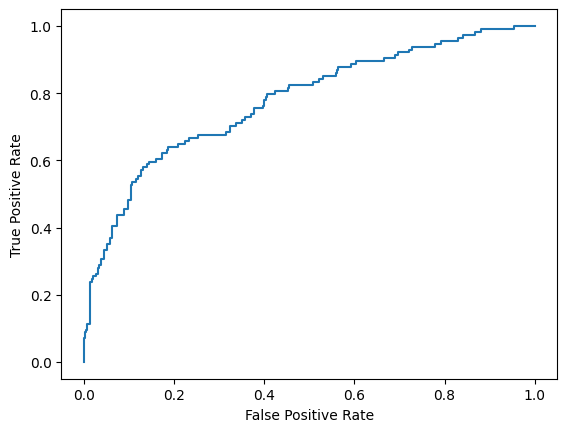

In [16]:
y_score = model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])

plt.figure()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.savefig('../src/visualization/modeling/metrics/roc_curve_base_model.png')
plt.show()

El modelo ha mostrado una precision en torno al 80%, la cual es relativamente buena, teniendo en cuenta todos los factores de procesamiento y optimizacion que no hemos aplicado en este primer modelo base. 

Podeos ver que este modelo base flaquea para predecir correctamente la clase 1, que corresponde a la clase de observaciones de personas con ingresos superiores a 50K. Es importante recordar que el modelo ha tenido una proporcion de 1/3 de ejemplos para esta clase en relacion a la clase contrario durante el entrenamiento, por lo que podemos esperar que este "error" sea corregido tras procesar correctamente el dataset para el entrenamiento final.

En este caso, el modelo obtiene un bajo coeficiente en metricas como F1-Score (y por tanto, en el recall y precision), que se debe en gran parte a la deficiencia del modelo actual en relacion a una de las clases, la que considera "positiva". En este sentido, **el modelo no clasifica correctamente los verdaderos positivos**, lo cual esperamos corregir con el procesamiento y optimizacion necesarios para la construccion del modelo final.

## Guardando el modelo base

In [17]:
base_model__route = '../src/models/'
joblib.dump(model, os.path.join(base_model__route, 'svc_base_model.joblib'))

print('El modelo base se ha guardado correctamente.')

El modelo base se ha guardado correctamente.
